In [1]:

import pandas as pd
import os


In [2]:
def load_PN_noun_data():
    pn_path = "~/Documents/MMI/corpus/PN/"
    pd.set_option('display.unicode.east_asian_width', True)
    df = pd.read_csv(pn_path+"noun_pn", names=['word', 'label', 'desc'], delimiter="\t")
    df = df[ (df.label=="p") | (df.label=="n") | (df.label=="e") ]
    df["label"] = df["label"].replace({'p':2, 'e':1, 'n':0})

    return df

In [3]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

import sys
sys.path.append("../")
from datatools.analyzer import *
from utterance.error_tools import *

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor

In [4]:
from gensim.models import KeyedVectors
w2v_path = "../../corpus/w2v/"
# fasttext
# https://qiita.com/Hironsan/items/513b9f93752ecee9e670
# w2v_name =  "dep-ja-300dim"
w2v_name =  "model.vec"
w2v_model = KeyedVectors.load_word2vec_format(w2v_path+w2v_name)

[23815] 2021-12-24 15:24:38,837 Info gensim.models.keyedvectors :loading projection weights from ../../corpus/w2v/model.vec
[23815] 2021-12-24 15:25:40,936 Info gensim.utils :KeyedVectors lifecycle event {'msg': 'loaded (351122, 300) matrix of type float32 from ../../corpus/w2v/model.vec', 'binary': False, 'encoding': 'utf8', 'datetime': '2021-12-24T15:25:40.936499', 'gensim': '4.0.1', 'python': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.72-microsoft-standard-WSL2-x86_64-with-Ubuntu-18.04-bionic', 'event': 'load_word2vec_format'}


In [5]:
denial_list = "無 非　未　不".split()
def is_in_denimal(word):
    for denial in denial_list:
        if denial == word[0]:
            return True
    return False
print(denial_list)

['無', '非', '未', '不']


In [6]:
df_noun = load_PN_noun_data()

In [7]:
def make_Xy_pn(df):
    X = []
    y = []
    
    for x, la in zip(df.word, df.label):

        if x not in w2v_model:
            continue
        else:
            # if is_in_denimal(x):
            #     print(x)

            X.append( (x,w2v_model[x] ) )
            y.append(la)
    
    return X, y

In [8]:
X, y = make_Xy_pn(df_noun)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim

In [10]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [11]:
X_train_str, X_test_str, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [12]:
leng = len(y_train)
print(leng)
for i, v in enumerate(y_train):
    if leng %(i+1) == 0:
        print(i+1, end=", ")

7811
1, 73, 107, 7811, 

In [13]:
X_train = torch.tensor( [xt[1] for xt in X_train_str] ) 
X_test =  torch.tensor( [xt[1] for xt in X_test_str]) 
y_train = torch.tensor( y_train ) 
y_test = torch.tensor( y_test ) 

In [14]:
BATCH_SIZE = 155
epoch_ = 300
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [15]:
class PNModel(nn.Module):
    def __init__(self, embedding_dim, tagset_size):
        # 親クラスのコンストラクタ。決まり文句
        super(PNModel, self).__init__()    
        self.embedding_dim = embedding_dim
        self.hid1= embedding_dim*2
        self.hid2 = embedding_dim//2
        # self.fb_dim = 4
        # self.fb_dim = 0
        self.fc1 = nn.Linear(self.embedding_dim, self.hid1)
        self.fc2 = nn.Linear(self.hid1, self.hid2)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        # self.hidden2tag = nn.Linear(self.hid2+self.fb_dim, tagset_size)
        self.hidden2tag = nn.Linear(self.hid2, tagset_size)
    
    def forward(self, x):
        # fb = x[:, :self.fb_dim]
        y = F.relu(self.fc1(x))
        # y = F.relu(self.fc1(x[]))
        y = F.relu(self.fc2(y))
        y = self.hidden2tag( y )
        y = F.log_softmax(y, dim=1)
        return y

In [16]:
EMBEDDING_DIM = 300
HIDDEN_DIM = EMBEDDING_DIM*2
OUTPUT_DIM = 3
# seq_len = length
print(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

300 600 3


In [17]:
model = PNModel(EMBEDDING_DIM, OUTPUT_DIM)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [18]:
losses = []
loss_border = 0.0001
for epoch in range(epoch_): 
    all_loss = 0
    for data in trainloader:
        # X_t_tensor = torch.tensor(data[0], device='cuda:0')
        X_t_tensor = data[0].cuda()
        # y_t_tensor = torch.tensor(data[1], device='cuda:0')
        y_t_tensor = data[1].cuda()
        optimizer.zero_grad()
        model.zero_grad()
        # print(X_t_tensor.shape)
        score = model(X_t_tensor)
        loss_ = loss_function(score, y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 50 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
    # if all_loss <= loss_border:
    #     print("loss was under border(={0}) : train end".format(loss_border))
    #     break
print("done")

epoch 50 	 loss 17.671637624502182
epoch 100 	 loss 2.5397991091012955
epoch 150 	 loss 0.28419510810635984
epoch 200 	 loss 0.09209657175233588
epoch 250 	 loss 0.07086185642401688
epoch 300 	 loss 0.02706228986789938
done


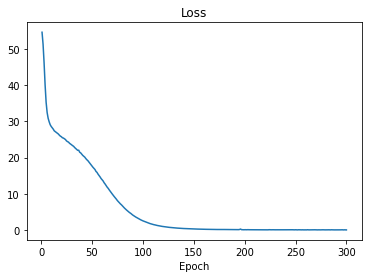

In [19]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [20]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0').float()
    y_tensor = torch.tensor(y_test, dtype=torch.long, device='cuda:0')
            # 推論
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[555 147  21]
 [104 553  84]
 [ 31 139 319]]
accuracy =  0.7306707629288275


In [22]:
model_path = "../models/social/"
model_name = "pn_dnn_v1.pickle"
modelM = DataManager(model_path)
modelM.save_data(model_name, model)

success save : ../models/social/pn_dnn_v1.pickle


In [23]:
test_words = "死者 熱中症 いい 悪い".split()
y_test_1 = [0, 0, 1, 0]

In [24]:
x_test_1 = [ w2v_model[w] for w in test_words]

In [28]:
with torch.no_grad():
    X_tensor = torch.tensor(x_test_1, device='cuda:0').float()
    y_tensor = torch.tensor(y_test_1, dtype=torch.long, device='cuda:0')
            # 推論
    y_pred_1 = np.array(model(X_tensor).cpu()).argmax(axis=1)

In [29]:
y_pred_1

array([0, 0, 2, 0])